what_were_covering = {

    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.9.0+cu126'

#Data (preparing and loading)

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these **parameters** using **gradient descent**.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Split data into training and test sets

In [ ]:
# Create train/test split
train_split=int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Let's create a function to visualize it.

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

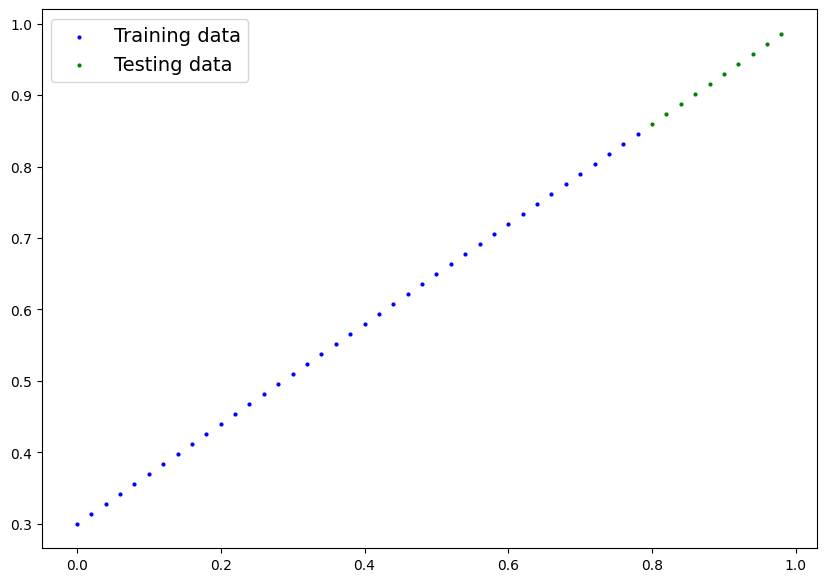

In [ ]:
plot_predictions();

#Build model

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

## Checking the contents of a PyTorch model

In [ ]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using torch.inference_mode()

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


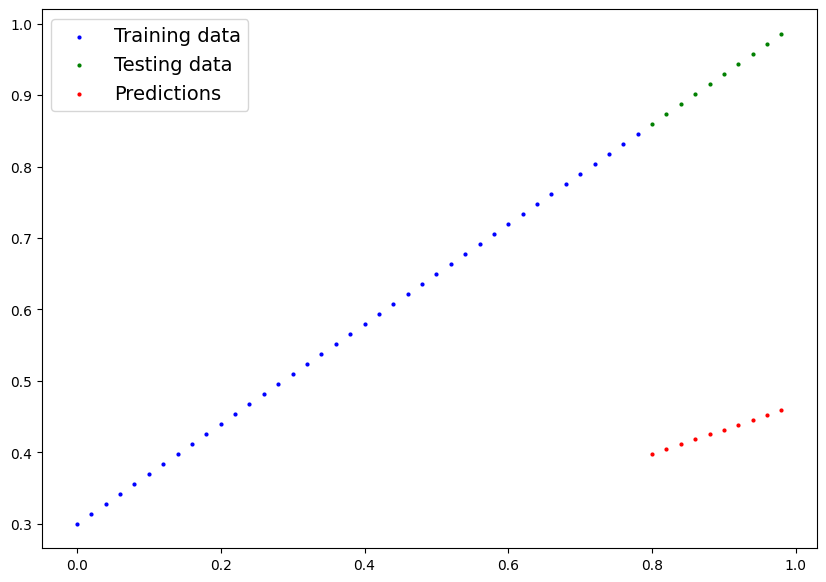

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

#Train Model  
### Loss Function & Optimizer (PyTorch)

| **Component** | **Purpose** | **PyTorch Location** | **Common Examples** |
|--------------|------------|----------------------|---------------------|
| **Loss Function** | Measures how wrong the model’s predictions are | `torch.nn` | Regression → `nn.L1Loss`<br>Binary Class → `nn.BCELoss` |
| **Optimizer** | Updates model parameters to reduce loss | `torch.optim` | `optim.SGD`<br>`optim.Adam` |

---

### 🧠 Key Idea
- **Loss Function** → How wrong is the model?  
- **Optimizer** → How do we reduce the error?


In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

#Prediction using inference

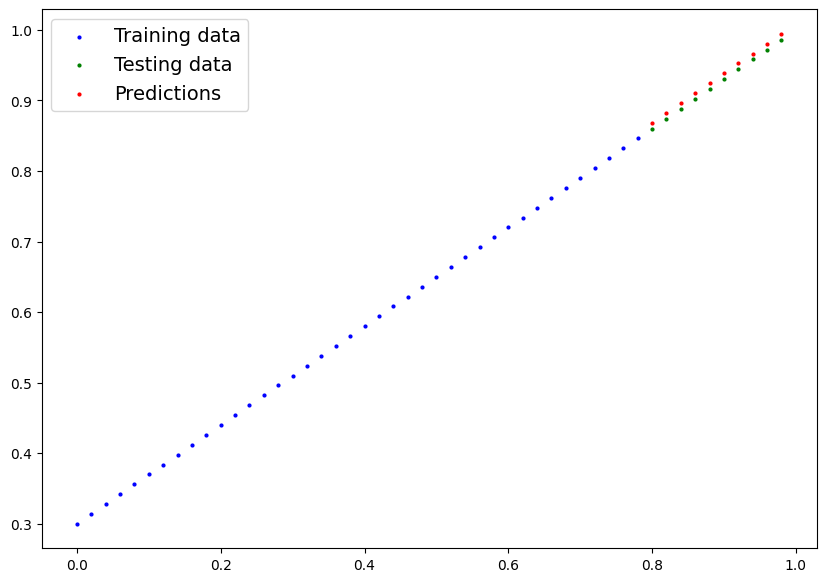

In [ ]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)


plot_predictions(predictions=y_preds_new)

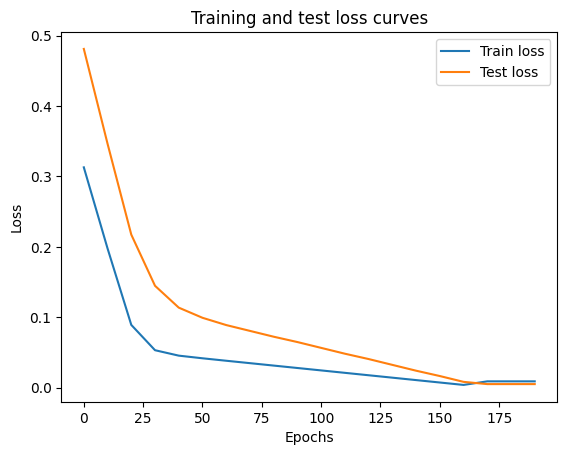

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

#Saving and loading a PyTorch model
| Topic | Explanation |
|------|-------------|
| Why save a model | Saving a model allows reuse of a trained model, deployment in applications, sharing with others, or continuing training later. |
| PyTorch mechanism | PyTorch uses Python’s pickle utility to serialize (save) and deserialize (load) models, tensors, and dictionaries. |
| torch.save | Used to save a serialized object to disk. It can store models, tensors, dictionaries, and model state_dicts. |
| torch.load | Used to load saved objects back into memory. It deserializes files created using torch.save and can load them on CPU or GPU. |
| load_state_dict | Loads only the model’s parameters (weights and biases) into an existing model architecture. |
| state_dict | A Python dictionary containing model parameters such as weights and biases. It does not store the model architecture. |
| Recommended practice | Save only the model’s state_dict and reload it into a model with the same architecture. |
| Security note | PyTorch uses pickle, which is not secure. Only load models from trusted sources. |
| One-line summary | torch.save saves objects, torch.load loads them, and load_state_dict restores model parameters. |


###Saving a PyTorch model's state_dict()

1. We'll create a directory for saving models to called models using Python's pathlib module.
2. We'll create a file path to save the model to.


1.  We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.





In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


###Loading a saved PyTorch model's state_dict()

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Checking the loaded model


In [ ]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

###check if the old model value and this model value are matching

In [ ]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)

In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

#Putting it all together

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


##Data

In [ ]:
weight=0.7
bias=0.3
start=0
end=1
step=0.003

X=torch.arange(start,end,step).unsqueeze(dim=1)
Y=weight*X+bias
X[:5],Y[:5]


(tensor([[0.0000],
         [0.0030],
         [0.0060],
         [0.0090],
         [0.0120]]),
 tensor([[0.3000],
         [0.3021],
         [0.3042],
         [0.3063],
         [0.3084]]))

In [ ]:
#split the data
train_split=int(0.8*len(X))
X_train, y_train = X[:train_split], Y[:train_split]
X_test, y_test = X[train_split:], Y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(267, 267, 67, 67)

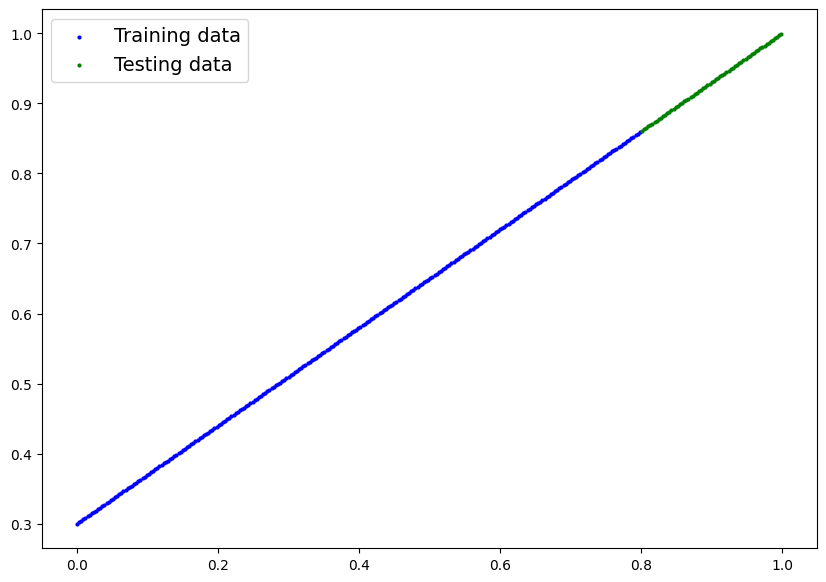

In [ ]:
plot_predictions(X_train,y_train,X_test,y_test)

##Building a PyTorch linear mode

In [ ]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer=nn.Linear(in_features=1,out_features=1)
    # Define the forward computation (input data x flows through nn.Linear())
  def forward(self, x: torch.Tensor) -> torch.Tensor:
     return self.linear_layer(x)
# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

##Training

In [ ]:
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [ ]:
torch.manual_seed(42)
epochs=10000
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_pred=model_1(X_train)
  loss=loss_fn(y_pred,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_1.eval()
  with torch.inference_mode():
    test_pred=model_1(X_test)
    test_loss=loss_fn(test_pred,y_test)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.5557588338851929 | MAE Test Loss: 0.5745015740394592 
Epoch: 100 | MAE Train Loss: 0.006881577894091606 | MAE Test Loss: 0.015281064435839653 
Epoch: 200 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 300 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 400 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 500 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 600 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 700 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 800 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 900 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 1000 | MAE Train Loss: 0.009619327262043953 | MAE Test Loss: 0.0003702471440192312 
Epoch: 1100 | MAE

In [ ]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6914]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2938], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


##Making predictions

In [ ]:
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds[:10]
y_train[:10]

tensor([[0.3000],
        [0.3021],
        [0.3042],
        [0.3063],
        [0.3084],
        [0.3105],
        [0.3126],
        [0.3147],
        [0.3168],
        [0.3189]], device='cuda:0')

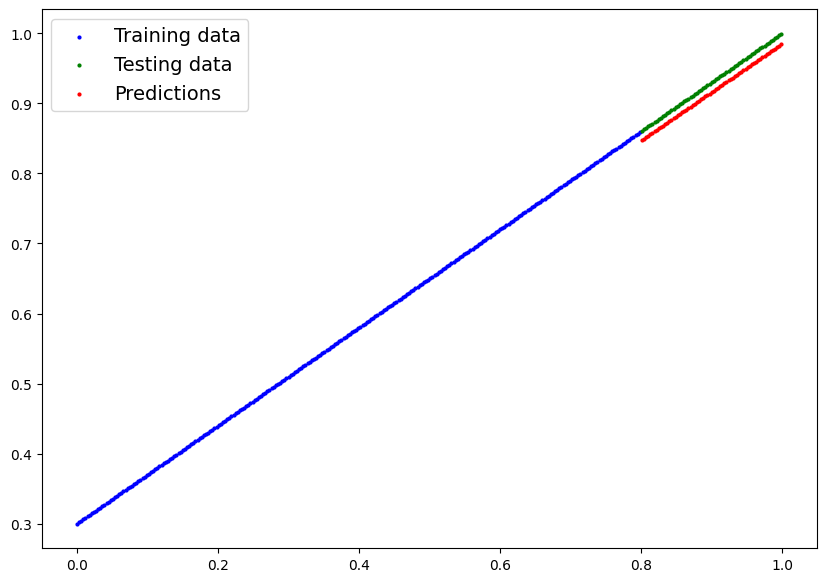

In [ ]:
plot_predictions(
    X_train.cpu(),
    y_train.cpu(),
    X_test.cpu(),
    y_test.cpu(),
    predictions=y_preds.cpu()
)


##Saving and loading a model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        